# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from __future__ import print_function

import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10
from cs231n.classifiers.neural_net import TwoLayerNet


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def getCIFAR10Data(numTraining = 49000, numValidation = 1000, numTest = 1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10Dir = 'cs231n/datasets/cifar-10-batches-py'
    XTrain, yTrain, XTest, yTest = load_CIFAR10(cifar10Dir)
        
    # Subsample the data
    mask = range(numTraining, numTraining + numValidation)
    XVal = XTrain[mask]
    yVal = yTrain[mask]
    mask = range(numTraining)
    XTrain = XTrain[mask]
    yTrain = yTrain[mask]
    mask = range(numTest)
    XTest = XTest[mask]
    yTest = yTest[mask]
    
    return XTrain, yTrain, XVal, yVal, XTest, yTest
    
## Invoke the above function to get our data.
XTrain, yTrain, XVal, yVal, XTest, yTest = getCIFAR10Data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

## Number of bins in the color histogram.
numColorBins = 10 
featureFns = [hog_feature, lambda img: color_histogram_hsv(img, nbin = numColorBins)]
XTrainFeats = extract_features(XTrain, featureFns, verbose = True)
XValFeats = extract_features(XVal, featureFns)
XTestFeats = extract_features(XTest, featureFns)

## Preprocessing: Subtract the mean feature.
meanFeat = np.mean(XTrainFeats, axis = 0, keepdims = True)
XTrainFeats -= meanFeat
XValFeats -= meanFeat
XTestFeats -= meanFeat

## Preprocessing: Divide by standard deviation. This ensures that each feature
## has roughly the same scale.
stdFeat = np.std(XTrainFeats, axis = 0, keepdims = True)
XTrainFeats /= stdFeat
XValFeats /= stdFeat
XTestFeats /= stdFeat

## Preprocessing: Add a bias dimension.
XTrainFeats = np.hstack([XTrainFeats, np.ones((XTrainFeats.shape[0], 1))])
XValFeats = np.hstack([XValFeats, np.ones((XValFeats.shape[0], 1))])
XTestFeats = np.hstack([XTestFeats, np.ones((XTestFeats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
## Use the validation set to tune the learning rate and regularization strength
from cs231n.classifiers.linear_classifier import LinearSVM

learningRates = [1e-8, 1e-7, 2e-7]
regularizationStrengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
bestVal = -1   # The highest validation accuracy that we have seen so far.
bestSvm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
## Initialising the SVM Classifier.
svm = LinearSVM()

for lr in learningRates:
    for reg in regularizationStrengths:
        
        ## Obtaining the loss history for the current hyperparameters.
        lossHist = svm.train(XTrainFeats, yTrain, learningRate = lr, reg = reg, numIters = 1500)
        
        ## Performing predictions on the training set.
        yTrainPred = svm.predict(XTrainFeats)
        
        ## Computing the training accuracy.
        accTrain = np.mean(yTrain == yTrainPred)
        
        ## Performing predictions on the validation set.
        yValPred = svm.predict(XValFeats)
        
        ## Computing the validation accuracy.
        accVal = np.mean(yVal == yValPred)
        
        ## Store the results in the dictionary.
        results[(lr, reg)] = (accTrain, accVal)
        
        if accVal > bestVal:
            bestVal = accVal
            bestSvm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
## Print out results.
for lr, reg in sorted(results):
    trainAccuracy, valAccuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, trainAccuracy, valAccuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % bestVal)

lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.083082 val accuracy: 0.088000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.089327 val accuracy: 0.096000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.415551 val accuracy: 0.420000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.415510 val accuracy: 0.416000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.416592 val accuracy: 0.421000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.413306 val accuracy: 0.414000
best validation accuracy achieved during cross-validation: 0.421000


In [5]:
## Evaluate your trained SVM on the test set.
yTestPred = bestSvm.predict(XTestFeats)
testAccuracy = np.mean(yTest == yTestPred)
print(testAccuracy)

0.414


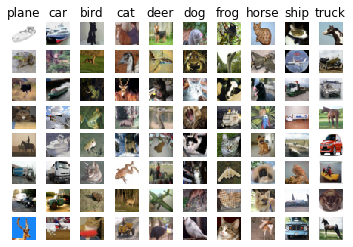

In [6]:
## An important way to gain intuition about how an algorithm works is to
## visualize the mistakes that it makes. In this visualization, we show examples
## of images that are misclassified by our current system. The first column
## shows images that our system labeled as "plane" but whose true label is
## something other than "plane".

examplesPerClass = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, clsName in enumerate(classes):
    idxs = np.where((yTest != cls) & (yTestPred == cls))[0]
    idxs = np.random.choice(idxs, examplesPerClass, replace = False)
    for i, idx in enumerate(idxs):
        plt.subplot(examplesPerClass, len(classes), i * len(classes) + cls + 1)
        plt.imshow(XTest[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(clsName)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
## Preprocessing: Remove the bias dimension.
## Make sure to run this cell only ONCE.
print(XTrainFeats.shape)
XTrainFeats = XTrainFeats[:, :-1]
XValFeats = XValFeats[:, :-1]
XTestFeats = XTestFeats[:, :-1]

print(XTrainFeats.shape)

(49000, 155)
(49000, 154)


In [8]:
# store the best model into this.
bestNet = None 
bestVal = -1

## Model initial parameters.
inputSize = XTrainFeats.shape[1]
hiddenSize = 500
numClasses = 10

batchSizes = [200, 236]
learningRates = [2e-1, 1e-4]
regularisationStrengths = [1e-3, 5e-1]

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in bestNet.                                                             #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################

## Converting the hyperparameter lists to numpy arrays.
batchSizes = np.array(batchSizes)
learningRates = np.array(learningRates)
regularisationStrengths = np.array(regularisationStrengths)

## Creating a grid search array which contains the different hyperparameter combinations.
gridArray = np.array(np.meshgrid(batchSizes, learningRates, regularisationStrengths)).T.reshape(8, 3)

## Iterating over each hyperparameter combination.
for i in range(gridArray.shape[0]):
    
    ## Setting the hyperparameter value.
    batchSize = gridArray[i][0]
    learningRate = gridArray[i][1]
    regularisationStrength = gridArray[i][2]
    
    ## Instantating the Neural Net.
    neuralNet = TwoLayerNet(inputSize, hiddenSize, numClasses)
    
    ## Training the network.
    neuralNet.train(XTrainFeats, yTrain, XValFeats, yVal, numIters = 3000, batchSize = batchSize, learningRate = learningRate, reg = regularisationStrength)
    
    ## Training Predictions.
    yPredTrain = neuralNet.predict(XTrainFeats)
    
    ## Validation Predictions.
    yPredValidation = neuralNet.predict(XValFeats)
    
    ## Computing training accuracy.
    trainAccuracy = np.mean(yPredTrain == yTrain)
    
    ## Computing validation accuracy.
    validationAccuracy = np.mean(yPredValidation == yVal)
    
    ## Comparing the current validation accuracy with the previous one.
    if (validationAccuracy > bestVal):
        
        bestVal = validationAccuracy
        bestNet = neuralNet
        
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

In [9]:
## Run your neural net classifier on the test set. You should be able to get more than 55% accuracy.
testAcc = (bestNet.predict(XTestFeats) == yTest).mean()
print('Test accuracy: ', testAcc)

Test accuracy:  0.589
